# Inerpretation-Net Training

# Experiment 1: I-Net Performance for Different Algebras and Complexities
# Experiment 2: I-Net Performance Comparison for λ-Nets with Different Training Levels
# Experiment 3: I-Net Performance Comparison Different Training Data Sizes

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes


config = {
    'data': {
        'd': 5, #degree
        'n': 1, #number of variables
        'sparsity': None,
        'sample_sparsity': None,
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        'a_max': 1,
        'a_min': -1,
        'lambda_nets_total': 10000,
        'noise': 0,
        'noise_distrib': 'normal', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        
        'same_training_all_lambda_nets': False,

        'fixed_seed_lambda_training': True,
        'fixed_initialization_lambda_training': False,
        'number_different_lambda_trainings': 1,
    },
    'lambda_net': {
        'epochs_lambda': 200,
        'batch_lambda': 64,
        'dropout': 0,
        'lambda_network_layers': [5*'sparsity'],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'r2',
        'number_of_lambda_weights': None,
        'lambda_dataset_size': 1000,
    },
    'i_net': {
        'optimizer': 'custom',#adam
        'inet_loss': 'r2',
        'inet_metrics': 'mae',
        'dropout': 0.25,
        'epochs': 100,
        'early_stopping': True,
        'batch_size': 512,
        'dense_layers': [512, 1024],
        'convolution_layers': None,
        'lstm_layers': None,
        'interpretation_dataset_size': 10000,
                
        'interpretation_net_output_monomials': None, #(None, int)
        'interpretation_net_output_shape': None, #calculated automatically later
        
        'evaluate_with_real_function': False,
        'consider_labels_training': False,
                      
        'data_reshape_version': None, #default to 2 options:(None, 0,1 2)
        'nas': False,
        'nas_type': None, #options:(None, 'CNN', 'LSTM', 'CNN-LSTM', 'CNN-LSTM-parallel')      
        'nas_trials': 0,
    },
    'evaluation': {   
        'inet_holdout_seed_evaluation': False,
        
        #set if multi_epoch_analysis should be performed
        'multi_epoch_analysis': True,
        'each_epochs_save_lambda': 20,
        'epoch_start': 0, #use to skip first epochs in multi_epoch_analysis
        
        #set if samples analysis should be performed
        'samples_list': None,#[100, 500, 750, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 25000, 28125] 
       
        'random_evaluation_dataset_size': 500,
    },
    'computation':{
        'n_jobs': 11,
        'use_gpu': False,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}

## Imports

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *


from itertools import product       
from tqdm import tqdm_notebook as tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer


import os
import shutil

import logging

from prettytable import PrettyTable
import colored
import math

import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score
from similaritymeasures import frechet_dist, area_between_two_curves, dtw
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.utils import plot_model
from IPython.display import Image

import keras.backend as K
from livelossplot import PlotLossesKerasTF
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from matplotlib import pyplot as plt
import seaborn as sns


import tensorflow as tf
import random 


import warnings


from IPython.display import display, Math, Latex



In [4]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################
variables = 'abcdefghijklmnopqrstuvwxyz'[:n]

n_jobs = min((epochs_lambda//each_epochs_save_lambda+1, n_jobs)) if multi_epoch_analysis else min(len(samples_list), n_jobs) if samples_list!=None else 1

each_epochs_save_lambda = each_epochs_save_lambda if multi_epoch_analysis else epochs_lambda
epochs_save_range_lambda = range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda) if each_epochs_save_lambda == 1 else range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda+1) if multi_epoch_analysis else range(1,2)

#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''

logging.getLogger('tensorflow').disabled = True

sns.set_style("darkgrid")
#np.set_printoptions(suppress=True)

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 500)

warnings.filterwarnings('ignore')

In [5]:
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################
config['evaluation']['each_epochs_save_lambda'] = each_epochs_save_lambda

config['data']['sparsity'] = nCr(config['data']['n']+config['data']['d'], config['data']['d'])
config['data']['sample_sparsity'] = config['data']['sparsity'] if config['data']['sample_sparsity'] == None else config['data']['sample_sparsity']

config['i_net']['interpretation_net_output_shape'] = config['data']['sparsity'] if config['i_net']['interpretation_net_output_monomials'] is None else 2*config['i_net']['interpretation_net_output_monomials']


transformed_layers = []
for layer in config['lambda_net']['lambda_network_layers']:
    if type(layer) == str:
        transformed_layers.append(layer.count('sparsity')*config['data']['sparsity'])
    else:
        transformed_layers.append(layer)
config['lambda_net']['lambda_network_layers'] = transformed_layers

layers_with_input_output = list(flatten([[config['data']['n']], config['lambda_net']['lambda_network_layers'], [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]  
config['lambda_net']['number_of_lambda_weights'] = number_of_lambda_weights
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])



initialize_LambdaNet_config_from_curent_notebook(config)
initialize_metrics_config_from_curent_notebook(config)
initialize_utility_functions_config_from_curent_notebook(config)
initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(path_type='interpretation_net'))
create_folders_inet()

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

In [6]:
print(path_identifier_interpretation_net_data)

print(path_identifier_lambda_net_data)


inet_dense[512, 1024]convNonelstmNoneoutput_6_drop0.25e100b512_customlnets_10000_30-200e64b_adam_r2_train_1000_var_1_d_5_sparsity_6_amin_-1_amax_1_xmin_0_xmax_1_xdist_uniform_noise_normal_0_diffX_1-FixSeed_42
lnets_10000_30-200e64b_adam_r2_train_1000_var_1_d_5_sparsity_6_amin_-1_amax_1_xmin_0_xmax_1_xdist_uniform_noise_normal_0_diffX_1-FixSeed_42


In [7]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


## Utility functions

### Generate List of Monomial Identifiers

In [8]:
list_of_monomial_identifiers_extended = []
for i in tqdm(range((d+1)**n)):    
    monomial_identifier = dec_to_base(i, base = (d+1)).zfill(n) 
    list_of_monomial_identifiers_extended.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(nCr(n+d, d)))
print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers_extended)

list_of_monomial_identifiers = []
for monomial_identifier in tqdm(list_of_monomial_identifiers_extended):
    monomial_identifier_values = list(map(int, list(monomial_identifier)))
    if sum(monomial_identifier_values) <= d:
        list_of_monomial_identifiers.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers)))
print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(nCr(n+d, d)))
print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers)


layers_with_input_output = list(flatten([[n], lambda_network_layers, [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]

  0%|          | 0/6 [00:00<?, ?it/s]

List length: 6
Number of monomials in a polynomial with 1 variables and degree 5: 6
Sparsity: 6
['0', '1', '2', '3', '4', '5']


  0%|          | 0/6 [00:00<?, ?it/s]

List length: 6
Number of monomials in a polynomial with 1 variables and degree 5: 6
Sparsity: 6
['0', '1', '2', '3', '4', '5']


## Load Data and Generate Datasets

In [9]:
def load_lambda_nets(index):
    
    if psutil.virtual_memory().percent > 80:
        raise SystemExit("Out of RAM!")
    
    path = './data/weights/' + 'weights_' + path_identifier_lambda_net_data + '/weights_' + path_identifier_lambda_net_data + '_epoch_' + str(index).zfill(3) + '.txt'

    
    weight_data = pd.read_csv(path, sep=",", header=None)
    weight_data = weight_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    weight_data = weight_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)

    lambda_nets = []
    for _, row in weight_data.iterrows():
        lambda_net = LambdaNet(row.values)
        lambda_nets.append(lambda_net)
        
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [10]:
#LOAD DATA

parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
del parallel

lambda_net_dataset = lambda_net_dataset_list[-1]


[Parallel(n_jobs=11)]: Using backend MultiprocessingBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of  11 | elapsed:    8.7s remaining:   39.2s
[Parallel(n_jobs=11)]: Done   6 out of  11 | elapsed:   13.9s remaining:   11.5s
[Parallel(n_jobs=11)]: Done  11 out of  11 | elapsed:   19.8s finished


## Data Inspection

In [11]:
lambda_net_dataset.as_pandas().head()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
6252,1373158606,0.924,0.492,-0.142,-0.402,-0.741,0.255,0.968,-0.045,2.179,-4.009,0.126,1.339,0.029,0.063,-0.945,2.038,-1.983,0.714,-0.009,-0.227,0.353,0.281,0.180,0.114,0.349,-0.297,0.266,-0.094,0.476,-0.088,-0.019,0.373,0.097,0.454,-0.033,0.205,0.277,0.237,-0.083,0.274,0.009,-0.042,-0.404,-0.090,0.262,-0.291,-0.209,-0.233,0.000,0.000,-0.153,-0.150,0.223,0.224,-0.189,0.000,-0.150,0.362,-0.174,0.000,0.000,-0.180,0.236,-0.161,0.222,0.250,0.214,0.235,0.301,-0.163,-0.021,0.000,0.000,0.000,-0.154,0.000,0.000,0.000,-0.254,-0.359,-0.445,-0.515,0.347,0.407,-0.318,-0.408,-0.589,0.165,-0.277,-0.352,-0.364,-0.307,0.350,-0.356,0.714,0.223,0.354,0.251,0.372,-0.808,-0.046,-0.261,-0.383,-0.059,-0.774,0.144,-0.258,-0.315,0.186
4684,1373158606,-0.794,0.241,-0.127,-0.188,-0.535,-0.939,-0.449,-1.141,0.078,0.047,-0.426,0.281,-0.036,-0.374,0.464,-0.963,0.929,-0.335,-0.009,-0.227,0.390,0.285,0.145,0.080,0.354,-0.297,0.252,0.447,0.519,-0.088,-0.019,0.399,0.079,0.500,0.008,0.371,0.241,0.227,0.033,0.199,0.164,-0.042,-0.404,-0.090,0.211,-0.291,-0.209,-0.233,0.000,0.000,0.095,0.095,-0.000,-0.081,0.101,0.000,0.095,0.123,0.099,0.000,0.000,0.099,-0.079,0.096,-0.024,-0.199,-0.000,-0.001,-0.040,0.094,0.113,0.000,0.000,0.000,0.094,0.000,0.000,0.000,-0.254,-0.359,-0.406,-0.404,0.100,0.187,-0.248,-0.408,-0.429,-0.137,-0.271,-0.352,-0.364,-0.265,0.121,-0.347,0.393,-0.233,0.161,0.034,0.048,-0.472,-0.207,-0.261,-0.383,-0.059,-0.499,0.144,-0.258,-0.315,-0.089
1731,1373158606,-0.739,0.951,0.737,0.786,0.773,0.083,-0.582,-1.453,13.051,-28.985,35.400,-15.163,0.030,0.086,-1.028,2.206,-2.142,0.770,-0.009,-0.227,0.145,0.088,0.729,0.630,0.124,-0.297,0.071,1.057,0.410,-0.088,-0.019,0.148,0.648,0.197,0.467,0.879,0.811,0.864,0.697,0.041,0.008,-0.042,-0.404,-0.090,0.048,-0.291,-0.209,-0.233,0.000,0.000,-0.148,-0.095,-0.208,-0.316,-0.124,0.000,-0.079,-0.590,-0.051,0.000,0.000,-0.148,-0.382,-0.197,-0.304,-0.220,-0.099,-0.132,-0.450,-0.054,-0.025,0.000,0.000,0.000,-0.060,0.000,0.000,0.000,-0.254,-0.359,-0.197,-0.225,0.722,0.794,-0.038,-0.408,-0.257,0.580,0.160,-0.352,-0.364,-0.032,0.748,-0.070,1.169,0.605,0.727,0.630,0.819,-0.309,-0.043,-0.261,-0.383,-0.059,-0.334,0.144,-0.258,-0.315,-0.614
4742,1373158606,0.173,-0.607,-0.085,0.746,-0.828,-0.939,0.138,0.620,-9.451,27.981,-34.287,13.625,-0.035,-0.371,0.454,-0.942,0.910,-0.329,-0.009,-0.227,0.515,0.423,0.088,0.069,0.525,-0.297,0.398,0.707,0.711,-0.088,-0.019,0.549,0.069,0.674,0.007,0.286,0.166,0.217,0.034,0.361,0.499,-0.042,-0.404,-0.090,0.363,-0.291,-0.209,-0.233,0.000,0.000,-0.252,-0.299,0.068,-0.078,-0.341,0.000,-0.290,-0.462,-0.045,0.000,0.000,-0.320,-0.077,-0.038,-0.026,-0.004,0.086,0.026,-0.044,-0.271,-0.377,0.000,0.000,0.000,-0.271,0.000,0.000,0.000,-0.254,-0.359,-0.598,-0.694,0.081,0.168,-0.514,-0.408,-0.753,-0.427,-0.427,-0.352,-0.364,-0.487,0.101,-0.502,0.392,-0.099,0.108,-0.033,0.048,-0.869,-0.897,-0.261,-0.383,-0.059,-0.871,0.144,-0.258,-0.315,0.136
4521,1373158606,0.131,0.208,0.871,0.323,0.573,0.164,0.098,0.452,-0.008,0.245,4.974,-3.801,0.030,0.083,-1.019,2.189,-2.126,0.765,-0.009,-0.227,0.133,0.085,0.573,0.497,0.113,-0.297,0.068,1.115,0.314,-0.088,-0.019,0.132,0.492,0.219,0.322,0.647,0.656,0.649,0.557,0.041,0.008,-0.042,-0.404,-0.090,0.047,-0.291,-0.209,-0.

In [12]:
lambda_net_dataset.as_pandas().describe()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
count,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000
mean,1373158606.000,0.001,-0.005,-0.000,0.004,-0.003,-0.003,0.001,0.001,-0.044,0.075,-0.010,-0.029,0.001,-0.121,-0.346,0.761,-0.744,0.268,-0.009,-0.227,0.288,0.194,0.287,0.226,0.262,-0.297,0.166,0.497,0.430,-0.088,-0.019,0.305,0.227,0.399,0.088,0.371,0.372,0.369,0.174,0.123,0.076,-0.042,-0.404,-0.090,0.133,-0.291,-0.209,-0.233,0.000,0.000,-0.013,-0.023,-0.005,-0.011,-0.035,0.000,-0.024,-0.105,-0.009,0.000,0.000,-0.026,-0.018,0.002,0.009,-0.030,0.015,-0.003,-0.023,-0.020,-0.006,0.000,0.000,0.000,-0.020,0.000,0.000,0.000,-0.254,-0.359,-0.351,-0.384,0.328,0.382,-0.203,-0.408,-0.425,0.007,-0.183,-0.352,-0.364,-0.202,0.322,-0.268,0.609,0.185,0.344,0.226,0.311,-0.496,-0.249,-0.261,-0.383,-0.059,-0.515,0.144,-0.258,-0.315,-0.000
std,0.000,0.574,0.577,0.577,0.577,0.575,0.580,0.515,0.834,3.610,10.704,14.458,6.274,0.032,0.215,0.724,1.537,1.488,0.535,0.000,0.000,0.139,0.135,0.157,0.152,0.146,0.000,0.133,0.289,0.135,0.000,0.000,0.141,0.160,0.143,0.144,0.162,0.158,0.161,0.221,0.134,0.205,0.000,0.000,0.000,0.131,0.000,0.000,0.000,0.000,0.000,0.132,0.136,0.147,0.153,0.156,0.000,0.135,0.315,0.127,0.000,0.000,0.146,0.166,0.123,0.133,0.180,0.126,0.148,0.205,0.132,0.178,0.000,0.000,0.000,0.130,0.000,0.000,0.000,0.000,0.000,0.137,0.155,0.156,0.165,0.166,0.000,0.167,0.294,0.156,0.000,0.000,0.160,0.172,0.142,0.235,0.197,0.149,0.172,0.253,0.203,0.275,0.000,0.000,0.000,0.190,0.000,0.000,0.000,0.134
min,1373158606.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.101,-3.351,-16.480,-47.761,-58.773,-29.301,-0.036,-0.375,-1.129,-1.332,-2.383,-0.464,-0.009,-0.227,-0.123,-0.336,-0.173,-0.221,-0.187,-0.297,-0.318,-0.270,0.125,-0.088,-0.019,-0.078,-0.238,0.036,-0.326,-0.127,-0.054,-0.077,-0.452,-0.308,-0.442,-0.042,-0.404,-0.090,-0.291,-0.291,-0.209,-0.233,0.000,0.000,-0.367,-0.409,-0.434,-0.451,-0.459,0.000,-0.402,-0.838,-0.397,0.000,0.000,-0.432,-0.480,-0.358,-0.456,-0.507,-0.379,-0.425,-0.540,-0.393,-0.505,0.000,0.000,0.000,-0.381,0.000,0.000,0.000,-0.254,-0.359,-0.883,-1.135,-0.001,0.112,-0.780,-0.408,-1.244,-1.128,-0.713,-0.352,-0.364,-0.763,0.030,-0.785,0.363,-0.650,0.015,-0.312,-0.061,-1.535,-1.709,-0.261,

## Generate Datasets for Interpretation-Net training

In [13]:
#generate train, test and validation data for training

lambda_net_train_dataset_list = []
lambda_net_valid_dataset_list = []
lambda_net_test_dataset_list = []

for lambda_net_dataset in lambda_net_dataset_list:
    
    
    if inet_holdout_seed_evaluation:
        complete_seed_list = list(set(lambda_net_dataset.train_settings_list['seed']))#list(weight_data.iloc[:,1].unique())

        random.seed(RANDOM_SEED)
        test_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/0.9)))
        lambda_net_test_dataset = lambda_net_dataset.get_lambda_nets_by_seed(test_seeds)
        complete_seed_list = list(set(complete_seed_list) - set(test_seeds))#complete_seed_list.remove(test_seeds)
        
        random.seed(RANDOM_SEED)
        valid_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/0.9)))
        lambda_net_valid_dataset = lambda_net_dataset.get_lambda_nets_by_seed(valid_seeds)
        complete_seed_list = list(set(complete_seed_list) - set(valid_seeds))

        train_seeds = complete_seed_list
        lambda_net_train_dataset = lambda_net_dataset.get_lambda_nets_by_seed(train_seeds)       
        
        lambda_net_train_dataset_list.append(lambda_net_train_dataset)
        lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
        lambda_net_test_dataset_list.append(lambda_net_test_dataset)
        
        del lambda_net_dataset
    else:
        lambda_net_train_with_valid_dataset, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=0.1)
        lambda_net_train_dataset, lambda_net_valid_dataset = split_LambdaNetDataset(lambda_net_train_with_valid_dataset, test_split=0.1)

        lambda_net_train_dataset_list.append(lambda_net_train_dataset)
        lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
        lambda_net_test_dataset_list.append(lambda_net_test_dataset)
    
        del lambda_net_dataset, lambda_net_train_with_valid_dataset

        
del lambda_net_dataset_list

In [14]:
lambda_net_train_dataset_list[-1].as_pandas().shape

(8100, 110)

In [15]:
lambda_net_valid_dataset_list[-1].as_pandas().shape

(900, 110)

In [16]:
lambda_net_test_dataset_list[-1].as_pandas().shape

(1000, 110)

In [17]:
lambda_net_train_dataset_list[-1].as_pandas().head()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
3003,1373158606,-0.340,-0.876,-0.048,-0.460,0.430,0.914,-0.369,-1.376,5.693,-19.313,25.803,-11.099,-0.036,-0.374,0.464,-0.960,0.926,-0.334,-0.009,-0.227,0.325,0.219,0.342,0.308,0.280,-0.297,0.186,0.340,0.448,-0.088,-0.019,0.327,0.330,0.434,0.009,0.422,0.379,0.400,0.523,0.133,0.063,-0.042,-0.404,-0.090,0.146,-0.291,-0.209,-0.233,0.000,0.000,0.091,0.092,-0.215,-0.195,0.097,0.000,0.092,0.123,0.095,0.000,0.000,0.096,-0.210,0.092,-0.023,-0.267,-0.236,-0.251,-0.341,0.092,0.117,0.000,0.000,0.000,0.091,0.000,0.000,0.000,-0.254,-0.359,-0.353,-0.353,0.457,0.550,-0.195,-0.408,-0.380,-0.084,-0.216,-0.352,-0.364,-0.211,0.500,-0.293,0.394,0.319,0.444,0.343,0.939,-0.427,-0.177,-0.261,-0.383,-0.059,-0.452,0.144,-0.258,-0.315,-0.086
5985,1373158606,-0.496,-0.607,0.252,0.645,-0.276,-0.135,-0.514,-0.256,-1.816,5.704,-5.613,1.871,-0.035,-0.370,0.452,-0.931,0.894,-0.322,-0.009,-0.227,0.253,0.143,0.277,0.218,0.201,-0.297,0.110,0.235,0.376,-0.088,-0.019,0.251,0.219,0.362,0.010,0.331,0.362,0.346,0.239,0.055,-0.090,-0.042,-0.404,-0.090,0.069,-0.291,-0.209,-0.233,0.000,0.000,0.122,0.124,-0.109,-0.105,0.130,0.000,0.124,0.165,0.125,0.000,0.000,0.127,-0.111,0.122,-0.022,-0.130,-0.104,-0.115,-0.137,0.125,0.187,0.000,0.000,0.000,0.124,0.000,0.000,0.000,-0.254,-0.359,-0.317,-0.333,0.306,0.354,-0.167,-0.408,-0.368,-0.057,-0.172,-0.352,-0.364,-0.176,0.292,-0.249,0.394,0.182,0.331,0.217,0.342,-0.437,-0.281,-0.261,-0.383,-0.059,-0.455,0.144,-0.258,-0.315,-0.115
6925,1373158606,-0.316,0.287,0.323,-0.293,-0.713,0.105,-0.190,-0.143,0.000,-0.000,0.000,-0.000,-0.035,-0.371,0.458,-0.944,0.906,-0.326,-0.009,-0.227,0.272,0.166,0.248,0.187,0.226,-0.297,0.133,0.278,0.395,-0.088,-0.019,0.274,0.183,0.381,0.011,0.296,0.334,0.312,0.089,0.081,0.012,-0.042,-0.404,-0.090,0.093,-0.291,-0.209,-0.233,0.000,0.000,0.055,0.055,0.000,0.000,0.054,0.000,0.055,0.045,0.054,0.000,0.000,0.054,0.000,0.055,-0.019,0.000,-0.000,0.000,0.000,0.056,0.061,0.000,0.000,0.000,0.056,0.000,0.000,0.000,-0.254,-0.359,-0.291,-0.288,0.229,0.257,-0.132,-0.408,-0.313,-0.020,-0.157,-0.352,-0.364,-0.149,0.191,-0.233,0.395,0.112,0.270,0.152,0.087,-0.357,-0.104,-0.261,-0.383,-0.059,-0.383,0.144,-0.258,-0.315,-0.056
9619,1373158606,0.123,-0.670,0.322,-0.940,0.676,0.843,0.122,-0.960,3.238,-10.229,12.453,-4.309,0.025,0.002,-0.676,1.476,-1.448,0.525,-0.009,-0.227,0.305,0.199,0.465,0.417,0.267,-0.297,0.166,0.283,0.432,-0.088,-0.019,0.312,0.426,0.415,0.336,0.515,0.528,0.531,0.443,0.114,-0.002,-0.042,-0.404,-0.090,0.125,-0.291,-0.209,-0.233,0.000,0.000,-0.002,-0.001,-0.315,-0.321,-0.002,0.000,-0.001,0.037,-0.003,0.000,0.000,-0.002,-0.343,-0.003,-0.277,-0.376,-0.276,-0.325,-0.365,-0.001,-0.002,0.000,0.000,0.000,-0.001,0.000,0.000,0.000,-0.254,-0.359,-0.314,-0.308,0.710,0.839,-0.154,-0.408,-0.332,-0.013,-0.181,-0.352,-0.364,-0.172,0.793,-0.258,1.361,0.564,0.639,0.567,0.945,-0.373,-0.031,-0.261,-0.383,-0.059,-0.400,0.144,-0.258,-0.315,0.109
6916,1373158606,-0.533,-0.333,0.694,-0.708,0.255,-0.974,-0.376,-0.735,0.001,-0.003,0.003,-0.001,-0.035,-0.370,0.451,-0.932,0.897,-0.323,-0.009,-0.227,0.346,0.240,0.188,0.124,0.304,-0.297,0.207,0.376,0.471,-0.088,-0.019,0.350,0.121,0.455,0.008,0.237,0.272,0.252,0.034,0.155,0.100,-0.042,-0.404,-0.090,0.167,-0.291,-0.209,-0.233,0

In [18]:
lambda_net_valid_dataset_list[-1].as_pandas().head()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
8323,1373158606,0.310,0.452,0.977,-0.064,-0.261,0.704,0.120,1.606,-0.739,0.733,1.136,-1.053,0.030,0.088,-1.040,2.233,-2.167,0.779,-0.009,-0.227,0.133,0.085,0.474,0.408,0.112,-0.297,0.068,1.001,0.296,-0.088,-0.019,0.131,0.418,0.205,0.254,0.560,0.553,0.558,0.375,0.041,0.008,-0.042,-0.404,-0.090,0.047,-0.291,-0.209,-0.233,0.000,0.000,-0.133,-0.085,0.026,0.028,-0.112,0.000,-0.071,-0.530,-0.131,0.000,0.000,-0.131,0.023,-0.131,0.034,0.012,0.029,0.019,0.004,-0.049,-0.024,0.000,0.000,0.000,-0.054,0.000,0.000,0.000,-0.254,-0.359,-0.200,-0.226,0.429,0.461,-0.039,-0.408,-0.259,0.445,0.073,-0.352,-0.364,-0.026,0.398,-0.019,0.642,0.314,0.464,0.350,0.322,-0.310,-0.044,-0.261,-0.383,-0.059,-0.335,0.144,-0.258,-0.315,0.045
5392,1373158606,0.502,-0.666,-0.803,0.182,0.483,-0.702,0.494,-0.345,-3.385,7.947,-9.270,3.601,0.023,-0.168,-0.514,1.141,-1.132,0.413,-0.009,-0.227,0.482,0.361,0.086,0.009,0.454,-0.297,0.334,0.575,0.629,-0.088,-0.019,0.509,0.006,0.601,-0.170,0.193,0.176,0.180,-0.200,0.289,0.347,-0.042,-0.404,-0.090,0.296,-0.291,-0.209,-0.233,0.000,0.000,-0.071,-0.206,0.153,0.163,-0.155,0.000,-0.223,-0.258,-0.007,0.000,0.000,-0.023,0.162,-0.011,0.188,0.106,0.150,0.131,0.234,-0.218,-0.268,0.000,0.000,0.000,-0.218,0.000,0.000,0.000,-0.254,-0.359,-0.495,-0.529,0.165,0.249,-0.349,-0.408,-0.581,-0.246,-0.357,-0.352,-0.364,-0.355,0.184,-0.433,0.698,0.001,0.169,0.048,0.297,-0.661,-0.520,-0.261,-0.383,-0.059,-0.676,0.144,-0.258,-0.315,0.165
4718,1373158606,0.390,0.568,-0.964,0.190,0.177,-0.243,0.411,0.245,0.383,-1.661,0.533,0.261,0.030,0.089,-1.043,2.238,-2.172,0.781,-0.009,-0.227,0.325,0.225,0.197,0.132,0.289,-0.297,0.199,0.362,0.456,-0.088,-0.019,0.332,0.124,0.436,-0.016,0.239,0.287,0.260,-0.016,0.174,0.010,-0.042,-0.404,-0.090,0.175,-0.291,-0.209,-0.233,0.000,0.000,-0.127,-0.126,0.129,0.130,-0.150,0.000,-0.121,-0.054,-0.127,0.000,0.000,-0.143,0.134,-0.123,0.132,0.138,0.126,0.133,0.165,-0.113,-0.021,0.000,0.000,0.000,-0.112,0.000,0.000,0.000,-0.254,-0.359,-0.390,-0.420,0.254,0.301,-0.245,-0.408,-0.465,-0.058,-0.238,-0.352,-0.364,-0.250,0.238,-0.316,0.586,0.131,0.278,0.166,0.220,-0.579,-0.045,-0.261,-0.383,-0.059,-0.580,0.144,-0.258,-0.315,0.118
990,1373158606,-0.178,-0.531,-0.961,0.759,0.931,-0.317,-0.175,-1.112,4.170,-14.690,20.234,-8.847,-0.035,-0.371,0.455,-0.940,0.904,-0.326,-0.009,-0.227,0.319,0.213,0.353,0.312,0.275,-0.297,0.180,0.337,0.443,-0.088,-0.019,0.322,0.325,0.428,0.010,0.421,0.396,0.410,0.429,0.128,0.063,-0.042,-0.404,-0.090,0.140,-0.291,-0.209,-0.233,0.000,0.000,0.048,0.048,-0.209,-0.192,0.050,0.000,0.048,0.058,0.049,0.000,0.000,0.049,-0.210,0.048,-0.022,-0.263,-0.226,-0.243,-0.298,0.048,0.055,0.000,0.000,0.000,0.048,0.000,0.000,0.000,-0.254,-0.359,-0.332,-0.326,0.457,0.540,-0.171,-0.408,-0.349,-0.060,-0.199,-0.352,-0.364,-0.190,0.487,-0.275,0.395,0.322,0.447,0.346,0.780,-0.389,-0.116,-0.261,-0.383,-0.059,-0.417,0.144,-0.258,-0.315,-0.047
6498,1373158606,0.861,-0.387,-0.550,0.460,0.491,-0.056,0.772,-0.169,-0.015,0.035,-0.035,0.013,0.030,0.088,-1.041,2.235,-2.169,0.780,-0.009,-0.227,0.314,0.219,0.222,0.159,0.278,-0.297,0.191,0.096,0.433,-0.088,-0.019,0.319,0.149,0.417,0.013,0.260,0.314,0.284,0.008,0.044,0.009,-0.042,-0.404,-0.090,0.131,-0.291,-0.209,-0.233,0.000,0.000,-0.0

In [19]:
lambda_net_test_dataset_list[-1].as_pandas().head()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
7217,1373158606,0.715,0.432,0.981,-0.843,-0.740,-0.831,0.761,1.367,-9.904,34.954,-48.204,21.168,0.029,0.068,-0.965,2.079,-2.022,0.728,-0.009,-0.227,0.422,0.390,0.199,0.135,0.495,-0.297,0.385,0.057,0.535,-0.088,-0.019,0.487,0.123,0.495,-0.010,0.234,0.293,0.260,-0.024,0.410,0.010,-0.042,-0.404,-0.090,0.387,-0.291,-0.209,-0.233,0.000,0.000,-0.253,-0.245,0.197,0.197,-0.314,0.000,-0.245,0.272,-0.316,0.000,0.000,-0.302,0.206,-0.287,0.197,0.217,0.190,0.205,0.256,-0.266,-0.020,0.000,0.000,0.000,-0.249,0.000,0.000,0.000,-0.254,-0.359,-0.621,-0.769,0.335,0.390,-0.550,-0.408,-0.884,0.105,-0.423,-0.352,-0.364,-0.502,0.330,-0.498,0.672,0.210,0.347,0.241,0.322,-1.182,-0.046,-0.261,-0.383,-0.059,-1.123,0.144,-0.258,-0.315,0.169
8291,1373158606,-0.213,0.402,-0.761,-0.041,-0.451,-0.243,-0.145,0.061,-2.744,11.726,-18.935,8.879,-0.035,-0.371,0.453,-0.935,0.900,-0.324,-0.009,-0.227,0.333,0.390,0.198,0.135,0.504,-0.297,0.352,0.731,0.460,-0.088,-0.019,0.516,0.132,0.442,0.008,0.248,0.283,0.264,0.034,0.311,0.526,-0.042,-0.404,-0.090,0.308,-0.291,-0.209,-0.233,0.000,0.000,0.076,-0.188,-0.002,-0.001,-0.256,0.000,-0.207,-0.436,0.071,0.000,0.000,-0.231,-0.001,0.078,-0.024,-0.003,-0.003,-0.003,-0.039,-0.215,-0.371,0.000,0.000,0.000,-0.210,0.000,0.000,0.000,-0.254,-0.359,-0.352,-0.587,0.176,0.204,-0.462,-0.408,-0.645,-0.443,-0.214,-0.352,-0.364,-0.427,0.137,-0.293,0.393,0.057,0.216,0.098,0.049,-0.765,-0.943,-0.261,-0.383,-0.059,-0.758,0.144,-0.258,-0.315,-0.075
4607,1373158606,0.514,-0.410,-0.766,-0.485,-0.225,-0.896,0.464,1.161,-12.465,33.720,-43.010,18.154,-0.023,-0.322,0.212,-0.407,0.378,-0.134,-0.009,-0.227,0.651,0.524,-0.079,0.063,0.634,-0.297,0.493,0.821,0.856,-0.088,-0.019,0.684,0.067,0.808,0.007,0.428,0.049,0.108,0.032,0.450,0.555,-0.042,-0.404,-0.090,0.452,-0.291,-0.209,-0.233,0.000,0.000,-0.252,-0.342,0.325,-0.076,-0.382,0.000,-0.335,-0.428,-0.109,0.000,0.000,-0.326,-0.077,-0.111,-0.026,-0.007,0.290,0.217,-0.047,-0.316,-0.391,0.000,0.000,0.000,-0.316,0.000,0.000,0.000,-0.254,-0.359,-0.722,-0.801,0.309,0.159,-0.618,-0.408,-0.855,-0.499,-0.562,-0.352,-0.364,-0.597,0.095,-0.636,0.392,-0.196,0.239,0.062,0.045,-0.959,-0.869,-0.261,-0.383,-0.059,-0.966,0.144,-0.258,-0.315,0.306
5114,1373158606,-0.373,0.948,0.872,0.284,-0.963,0.497,-0.305,-0.153,6.383,-11.657,10.921,-3.963,0.030,0.083,-1.019,2.189,-2.126,0.765,-0.009,-0.227,0.136,0.087,0.486,0.420,0.116,-0.297,0.071,0.764,0.306,-0.088,-0.019,0.151,0.433,0.253,0.259,0.584,0.562,0.575,0.399,0.043,0.008,-0.042,-0.404,-0.090,0.049,-0.291,-0.209,-0.233,0.000,0.000,-0.136,-0.088,-0.040,-0.039,-0.116,0.000,-0.073,-0.409,-0.056,0.000,0.000,-0.120,-0.044,-0.067,-0.068,-0.047,-0.046,-0.046,-0.142,-0.050,-0.024,0.000,0.000,0.000,-0.055,0.000,0.000,0.000,-0.254,-0.359,-0.196,-0.228,0.458,0.499,-0.035,-0.408,-0.260,0.279,0.014,-0.352,-0.364,-0.011,0.438,-0.069,0.748,0.342,0.486,0.376,0.408,-0.311,-0.044,-0.261,-0.383,-0.059,-0.336,0.144,-0.258,-0.315,-0.298
1859,1373158606,0.664,-0.380,0.886,-0.641,0.325,0.344,0.514,0.428,-0.002,0.005,-0.005,0.002,0.030,0.084,-1.024,2.199,-2.136,0.768,-0.009,-0.227,0.242,0.081,0.294,0.231,0.198,-0.297,0.068,0.279,0.362,-0.088,-0.019,0.244,0.228,0.347,0.089,0.343,0.381,0.359,0.130,0.042,0.008,-0.042,-0.404,-0.090,0.049,-0.

## Interpretation Network Training

[Parallel(n_jobs=11)]: Using backend MultiprocessingBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   1 tasks      | elapsed: 10.9min
[Parallel(n_jobs=11)]: Done   2 out of  11 | elapsed: 11.2min remaining: 50.5min
[Parallel(n_jobs=11)]: Done   4 out of  11 | elapsed: 11.4min remaining: 19.9min
[Parallel(n_jobs=11)]: Done   6 out of  11 | elapsed: 12.1min remaining: 10.1min
[Parallel(n_jobs=11)]: Done   8 out of  11 | elapsed: 12.2min remaining:  4.6min
[Parallel(n_jobs=11)]: Done  11 out of  11 | elapsed: 14.9min finished


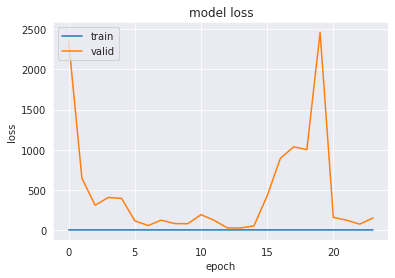

In [20]:
(history_list, 
scores_list, 

function_values_complete_list, 
function_values_valid_list, 
function_values_test_list, 

inet_preds_list, 
inet_preds_valid_list, 
inet_preds_test_list, 

distrib_dict_list,
model_list) = calculate_interpretation_net_results(lambda_net_train_dataset_list, 
                                                   lambda_net_valid_dataset_list, 
                                                   lambda_net_test_dataset_list)

## Evaluate Interpretation Net

In [21]:
if nas:
    for trial in history_list[-1]: 
        print(trial.summary())

In [22]:
if len(model_list) >= 1:
    print(model_list[-1].summary())
    print(model_list[-1].get_config())

In [23]:
scores_list[-1]

,MAE,RMSE,MAPE,Accuracy,Accuracy Multilabel,MAE FV,RMSE FV,MAPE FV,R2 FV,RAAE FV,RMAE FV,MEAN STD FV DIFF,MEAN FV1,MEAN FV2,STD FV1,STD FV2
inetPoly_VS_targetPoly_valid,0.402,0.487,13.734,0.082,0.000,0.211,0.246,1.423,-36.765,2.850,6.063,0.139,0.132,0.010,0.651,0.784
inetPoly_VS_targetPoly_test,0.401,0.488,13.813,0.080,0.000,0.216,0.251,1.325,-35.123,2.967,6.222,0.141,0.087,-0.053,0.650,0.773
inetPoly_VS_predLambda_valid,NaN,NaN,NaN,NaN,NaN,0.210,0.236,1.483,-30.226,2.773,4.355,0.123,0.132,0.010,0.651,0.776
inetPoly_VS_predLambda_test,NaN,NaN,NaN,NaN,NaN,0.214,0.240,1.316,-29.296,2.846,4.525,0.125,0.087,-0.053,0.650,0.765
inetPoly_VS_lstsqTarget_valid,0.851,1.093,28.739,0.054,0.000,0.528,0.565,1.509,-109.789,6.571,4.940,0.191,0.132,-0.088,0.651,0.094
inetPoly_VS_lstsqTarget_test,0.832,1.073,27.890,0.049,0.000,0.515,0.553,1.326,-124.770,6.843,3.953,0.190,0.087,-0.092,0.650,0.095
inetPoly_VS_lstsqLambda_valid,3.710,7.828,72.479,0.125,0.001,0.210,0.235,1.484,-30.219,2.773,4.352,0.122,0.132,0.010,0.651,0.775
inetPoly_VS_lstsqLambda_test,3.962,8.416,46.184,0.119,0.000,0.214,0.240,1.314,-29.291,2.845,4.528,0.125,0.087,-0.053,0.650,0.765
lstsqLambda_VS_predLambda_valid,NaN,NaN,NaN,NaN,NaN,0.003,0.004,0.046,0.999,0.014,0.047,0.004,0.010,0.010,0.775,0.776
lstsqLambda_VS_predLambda_test,NaN,NaN,NaN,NaN,NaN,0.003,0.004,0.035,0.999,0.014,0.044,0.004,-0.053,-0.053,0.765,0.765


In [24]:
distrib_dict_list[-1]['MAE']

,L-0,L-1,L-2,L-3,L-4,L-5,L-6,L-7,L-8,L-9,L-10,L-11,L-12,L-13,L-14,L-15,L-16,L-17,L-18,L-19,L-20,L-21,L-22,L-23,L-24,L-25,L-26,L-27,L-28,L-29,L-30,L-31,L-32,L-33,L-34,L-35,L-36,L-37,L-38,L-39,L-40,L-41,L-42,L-43,L-44,L-45,L-46,L-47,L-48,L-49,L-50,L-51,L-52,L-53,L-54,L-55,L-56,L-57,L-58,L-59,L-60,L-61,L-62,L-63,L-64,L-65,L-66,L-67,L-68,L-69,L-70,L-71,L-72,L-73,L-74,L-75,L-76,L-77,L-78,L-79,L-80,L-81,L-82,L-83,L-84,L-85,L-86,L-87,L-88,L-89,L-90,L-91,L-92,L-93,L-94,L-95,L-96,L-97,L-98,L-99,L-100,L-101,L-102,L-103,L-104,L-105,L-106,L-107,L-108,L-109,L-110,L-111,L-112,L-113,L-114,L-115,L-116,L-117,L-118,L-119,L-120,L-121,L-122,L-123,L-124,L-125,L-126,L-127,L-128,L-129,L-130,L-131,L-132,L-133,L-134,L-135,L-136,L-137,L-138,L-139,L-140,L-141,L-142,L-143,L-144,L-145,L-146,L-147,L-148,L-149,L-150,L-151,L-152,L-153,L-154,L-155,L-156,L-157,L-158,L-159,L-160,L-161,L-162,L-163,L-164,L-165,L-166,L-167,L-168,L-169,L-170,L-171,L-172,L-173,L-174,L-175,L-176,L-177,L-178,L-179,L-180,L-181,L-182,L-183,L-184,L-185,L-186,L-187,L-188,L-189,L-190,L-191,L-192,L-193,L-194,L-195,L-196,L-197,L-198,L-199,L-200,L-201,L-202,L-203,L-204,L-205,L-206,L-207,L-208,L-209,L-210,L-211,L-212,L-213,L-214,L-215,L-216,L-217,L-218,L-219,L-220,L-221,L-222,L-223,L-224,L-225,L-226,L-227,L-228,L-229,L-230,L-231,L-232,L-233,L-234,L-235,L-236,L-237,L-238,L-239,L-240,L-241,L-242,L-243,L-244,L-245,L-246,L-247,L-248,L-249,...,L-750,L-751,L-752,L-753,L-754,L-755,L-756,L-757,L-758,L-759,L-760,L-761,L-762,L-763,L-764,L-765,L-766,L-767,L-768,L-769,L-770,L-771,L-772,L-773,L-774,L-775,L-776,L-777,L-778,L-779,L-780,L-781,L-782,L-783,L-784,L-785,L-786,L-787,L-788,L-789,L-790,L-791,L-792,L-793,L-794,L-795,L-796,L-797,L-798,L-799,L-800,L-801,L-802,L-803,L-804,L-805,L-806,L-807,L-808,L-809,L-810,L-811,L-812,L-813,L-814,L-815,L-816,L-817,L-818,L-819,L-820,L-821,L-822,L-823,L-824,L-825,L-826,L-827,L-828,L-829,L-830,L-831,L-832,L-833,L-834,L-835,L-836,L-837,L-838,L-839,L-840,L-841,L-842,L-843,L-844,L-845,L-846,L-847,L-848,L-849,L-850,L-851,L-852,L-853,L-854,L-855,L-856,L-857,L-858,L-859,L-860,L-861,L-862,L-863,L-864,L-865,L-866,L-867,L-868,L-869,L-870,L-871,L-872,L-873,L-874,L-875,L-876,L-877,L-878,L-879,L-880,L-881,L-882,L-883,L-884,L-885,L-886,L-887,L-888,L-889,L-890,L-891,L-892,L-893,L-894,L-895,L-896,L-897,L-898,L-899,L-900,L-901,L-902,L-903,L-904,L-905,L-906,L-907,L-908,L-909,L-910,L-911,L-912,L-913,L-914,L-915,L-916,L-917,L-918,L-919,L-920,L-921,L-922,L-923,L-924,L-925,L-926,L-927,L-928,L-929,L-930,L-931,L-932,L-933,L-934,L-935,L-936,L-937,L-938,L-939,L-940,L-941,L-942,L-943,L-944,L-945,L-946,L-947,L-948,L-949,L-950,L-951,L-952,L-953,L-954,L-955,L-956,L-957,L-958,L-959,L-960,L-961,L-962,L-963,L-964,L-965,L-966,L-967,L-968,L-969,L-970,L-971,L-972,L-973,L-974,L-975,L-976,L-977,L-978,L-979,L-980,L-981,L-982,L-983,L-984,L-985,L-986,L-987,L-988,L-989,L-990,L-991,L-992,L-993,L-994,L-995,L-996,L-997,L-998,L-999
inetPoly_VS_targetPoly_valid,0.157,0.358,0.236,0.161,0.130,0.116,0.177,0.203,0.085,0.300,0.091,0.169,0.492,0.099,0.150,0.207,0.101,0.227,0.173,0.118,0.370,0.067,0.175,0.128,0.059,0.112,0.118,0.058,0.151,0.234,0.105,0.077,0.232,0.210,0.140,0.360,0.217,0.274,0.136,0.151,0.214,0.046,0.132,0.092,0.113,0.270,0.182,0.325,0.128,0.225,0.277,0.164,0.201,0.315,0.256,0.152,0.058,0.194,0.647,0.086,0.825,0.216,0.068,0.280,0.193,0.238,0.221,0.462,0.157,0.374,0.073,0.124,0.076,0.043,0.141,0.183,0.112,0.087,0.269,0.204,0.147,0.145,0.344,0.206,0.184,0.097,0.288,0.228,0.382,0.335,0.215,0.107,0.095,0.092,0.187,0.203,0.084,0.050,0.100,0.204,0.267,0.093,0.182,0.216,0.216,0.113,0.115,0.242,0.196,0.361,0.206,0.109,0.171,0.665,0.157,0.109,0.229,0.104,0.147,0.198,0.206,0.135,0.088,0.259,0.191,0.127,0.032,0.329,0.329,0.198,0.381,0.371,0.209,0.444,0.194,0.214,0.139,0.195,0.121,0.141,0.221,0.126,0.240,0.284,0.154,0.060,0.290,0.090,0.427,0.147,0.117,0.326,0.397,0.251,0.246,0.171,0.477,0.194,0.082,0.499,0.272,0.231,0.124,0.143,0.445,0.354,0.168,0.123,0.269,0.204,0.404,0.076,0.257,0.033,0.245,0.130,0.358,0.210,0.177,0.

In [25]:
distrib_dict_list[-1]['R2']

,L-0,L-1,L-2,L-3,L-4,L-5,L-6,L-7,L-8,L-9,L-10,L-11,L-12,L-13,L-14,L-15,L-16,L-17,L-18,L-19,L-20,L-21,L-22,L-23,L-24,L-25,L-26,L-27,L-28,L-29,L-30,L-31,L-32,L-33,L-34,L-35,L-36,L-37,L-38,L-39,L-40,L-41,L-42,L-43,L-44,L-45,L-46,L-47,L-48,L-49,L-50,L-51,L-52,L-53,L-54,L-55,L-56,L-57,L-58,L-59,L-60,L-61,L-62,L-63,L-64,L-65,L-66,L-67,L-68,L-69,L-70,L-71,L-72,L-73,L-74,L-75,L-76,L-77,L-78,L-79,L-80,L-81,L-82,L-83,L-84,L-85,L-86,L-87,L-88,L-89,L-90,L-91,L-92,L-93,L-94,L-95,L-96,L-97,L-98,L-99,L-100,L-101,L-102,L-103,L-104,L-105,L-106,L-107,L-108,L-109,L-110,L-111,L-112,L-113,L-114,L-115,L-116,L-117,L-118,L-119,L-120,L-121,L-122,L-123,L-124,L-125,L-126,L-127,L-128,L-129,L-130,L-131,L-132,L-133,L-134,L-135,L-136,L-137,L-138,L-139,L-140,L-141,L-142,L-143,L-144,L-145,L-146,L-147,L-148,L-149,L-150,L-151,L-152,L-153,L-154,L-155,L-156,L-157,L-158,L-159,L-160,L-161,L-162,L-163,L-164,L-165,L-166,L-167,L-168,L-169,L-170,L-171,L-172,L-173,L-174,L-175,L-176,L-177,L-178,L-179,L-180,L-181,L-182,L-183,L-184,L-185,L-186,L-187,L-188,L-189,L-190,L-191,L-192,L-193,L-194,L-195,L-196,L-197,L-198,L-199,L-200,L-201,L-202,L-203,L-204,L-205,L-206,L-207,L-208,L-209,L-210,L-211,L-212,L-213,L-214,L-215,L-216,L-217,L-218,L-219,L-220,L-221,L-222,L-223,L-224,L-225,L-226,L-227,L-228,L-229,L-230,L-231,L-232,L-233,L-234,L-235,L-236,L-237,L-238,L-239,L-240,L-241,L-242,L-243,L-244,L-245,L-246,L-247,L-248,L-249,...,L-750,L-751,L-752,L-753,L-754,L-755,L-756,L-757,L-758,L-759,L-760,L-761,L-762,L-763,L-764,L-765,L-766,L-767,L-768,L-769,L-770,L-771,L-772,L-773,L-774,L-775,L-776,L-777,L-778,L-779,L-780,L-781,L-782,L-783,L-784,L-785,L-786,L-787,L-788,L-789,L-790,L-791,L-792,L-793,L-794,L-795,L-796,L-797,L-798,L-799,L-800,L-801,L-802,L-803,L-804,L-805,L-806,L-807,L-808,L-809,L-810,L-811,L-812,L-813,L-814,L-815,L-816,L-817,L-818,L-819,L-820,L-821,L-822,L-823,L-824,L-825,L-826,L-827,L-828,L-829,L-830,L-831,L-832,L-833,L-834,L-835,L-836,L-837,L-838,L-839,L-840,L-841,L-842,L-843,L-844,L-845,L-846,L-847,L-848,L-849,L-850,L-851,L-852,L-853,L-854,L-855,L-856,L-857,L-858,L-859,L-860,L-861,L-862,L-863,L-864,L-865,L-866,L-867,L-868,L-869,L-870,L-871,L-872,L-873,L-874,L-875,L-876,L-877,L-878,L-879,L-880,L-881,L-882,L-883,L-884,L-885,L-886,L-887,L-888,L-889,L-890,L-891,L-892,L-893,L-894,L-895,L-896,L-897,L-898,L-899,L-900,L-901,L-902,L-903,L-904,L-905,L-906,L-907,L-908,L-909,L-910,L-911,L-912,L-913,L-914,L-915,L-916,L-917,L-918,L-919,L-920,L-921,L-922,L-923,L-924,L-925,L-926,L-927,L-928,L-929,L-930,L-931,L-932,L-933,L-934,L-935,L-936,L-937,L-938,L-939,L-940,L-941,L-942,L-943,L-944,L-945,L-946,L-947,L-948,L-949,L-950,L-951,L-952,L-953,L-954,L-955,L-956,L-957,L-958,L-959,L-960,L-961,L-962,L-963,L-964,L-965,L-966,L-967,L-968,L-969,L-970,L-971,L-972,L-973,L-974,L-975,L-976,L-977,L-978,L-979,L-980,L-981,L-982,L-983,L-984,L-985,L-986,L-987,L-988,L-989,L-990,L-991,L-992,L-993,L-994,L-995,L-996,L-997,L-998,L-999
inetPoly_VS_targetPoly_valid,0.700,-0.916,-18.892,-3.752,-12.223,0.251,-42.320,0.249,0.629,-148.257,-6.708,0.484,-6.143,-0.357,-21.040,-1.681,-0.088,0.624,0.122,-209.474,0.473,0.950,-0.249,0.884,0.752,-3.139,-1.585,0.682,-29.356,-0.059,0.919,0.318,-1.902,-3.517,-4.173,-1.532,-108.666,0.105,0.752,0.722,-2.333,0.975,-28.024,0.676,-19.064,-19.477,0.348,0.527,-0.313,-41.116,-2.172,0.669,-8.131,-116.905,-0.677,-8.041,0.395,-1.568,-6.509,0.936,-7.407,-1.726,-0.705,-0.605,0.732,-71.064,-85.741,-66.089,-0.895,-4.280,-2.949,-0.119,-1.341,0.609,-0.993,0.484,-0.436,0.946,-2.808,0.669,0.772,0.815,-105.335,0.186,0.214,0.949,-15.772,0.765,-24.291,-22.432,-2.251,-6.761,-3.574,0.036,0.721,-245.456,0.926,0.941,-8.300,-3.631,0.390,0.802,-5.938,-58.205,0.740,0.833,0.122,-56.250,0.741,-2.938,-404.446,0.588,-5607.279,-3.678,0.613,-32.005,-51.932,0.904,-31.200,-48.510,0.284,0.739,-2.230,-0.288,-335.558,0.556,0.702,-1.080,0.294,0.720,-0.760,0.191,0.742,-32.116,0.056,0.720,0.522,-104.402,-1482.722,0.680,-19.690,-0.169,-63.888,-8.818,-4.810,-0.203,-53.420,-2.174,-24.007,0.803,-5.570,-0.490,-16.872,-48.720,-4.824,

In [26]:
index_min = int(np.argmin(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
polynomial_inet = inet_preds_test_list[-1][index_min]

print(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][index_min])

print_polynomial_from_coefficients(polynomial_inet)

-9.10184319865695


<IPython.core.display.Math object>

In [27]:
index_min = int(np.argmin(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial

print(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][index_min])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_lambda)

-195.0483632403382


<IPython.core.display.Math object>

In [28]:
index_min = int(np.argmin(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial
polynomial_target = lambda_net_test_dataset.target_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_target)

<IPython.core.display.Math object>

In [29]:
index_max = int(np.argmax(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
polynomial_inet = inet_preds_test_list[-1][index_max]

print(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][index_max])

print_polynomial_from_coefficients(polynomial_inet)

-779.1248692334176


<IPython.core.display.Math object>

In [30]:
index_max = int(np.argmax(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial

print(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][index_max])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_max]
print_polynomial_from_coefficients(polynomial_lambda)

-0.17471836475752234


<IPython.core.display.Math object>

In [31]:
index_max = int(np.argmax(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial
polynomial_target = lambda_net_test_dataset.target_polynomial_list[index_max]
print_polynomial_from_coefficients(polynomial_target)

<IPython.core.display.Math object>

In [32]:
r2_values_inet = distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test']
print('Mean: ' + str(np.mean(r2_values_inet)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_inet = r2_values_inet[r2_values_inet>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_inet)) + ' (' + str(r2_values_positive_inet.shape[0]) + ' Samples)')



Mean: -35.12297282529499 (1000 Samples)
Mean (only positive): 0.5595328931060757 (351 Samples)


In [33]:
r2_values_lstsq_lambda = distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test']
print('Mean: ' + str(np.mean(r2_values_lstsq_lambda)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_lstsq_lambda = r2_values_lstsq_lambda[r2_values_lstsq_lambda>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_lstsq_lambda)) + ' (' + str(r2_values_positive_lstsq_lambda.shape[0]) + ' Samples)')



Mean: -0.7903978511365922 (1000 Samples)
Mean (only positive): 0.9143736040152183 (910 Samples)


<AxesSubplot:xlabel='inetPoly_VS_targetPoly_test', ylabel='Count'>

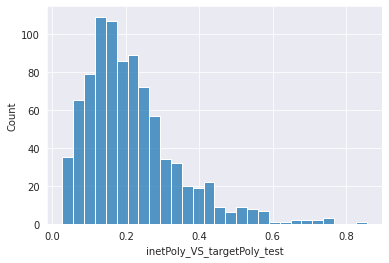

In [34]:
sns.histplot(distrib_dict_list[-1]['MAE'].loc['inetPoly_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'] > -50])


<AxesSubplot:xlabel='lstsqLambda_VS_targetPoly_test', ylabel='Count'>

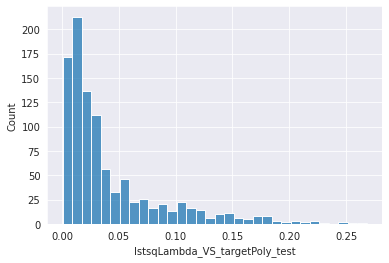

In [35]:
sns.histplot(distrib_dict_list[-1]['MAE'].loc['lstsqLambda_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'] > -50])


[(-30.0, 1.0)]

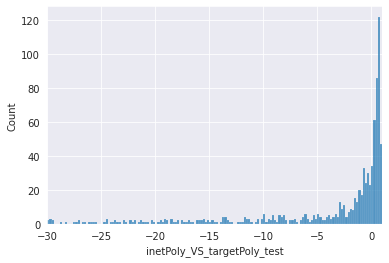

In [36]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'] > -50], binwidth=0.2)
p.set(xlim=(-30, 1))

[(0.0, 1.0)]

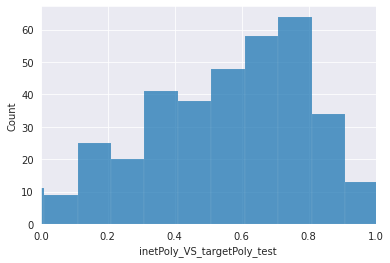

In [37]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'] > -50], binwidth=0.1)
p.set(xlim=(0, 1))

[(-10.0, 1.0)]

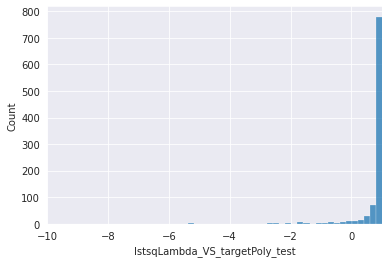

In [38]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'] > -50], binwidth=0.2)
p.set(xlim=(-10, 1))

[(0.0, 1.0)]

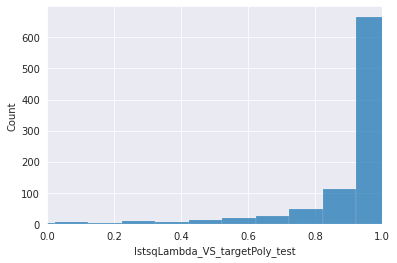

In [39]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'] > -50], binwidth=0.1)
p.set(xlim=(0, 1))

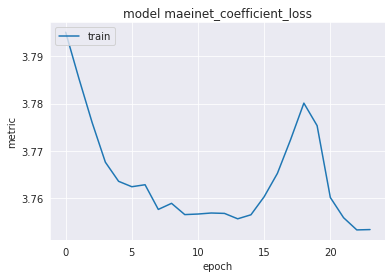

In [40]:
if not nas:
    history = history_list[-1]

    plt.plot(history[list(history.keys())[1]])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history[list(history.keys())[len(history.keys())//2+1]]) 
    plt.title('model ' + list(history.keys())[1])
    plt.ylabel('metric')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/metric_' + path_identifier_interpretation_net_data + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')


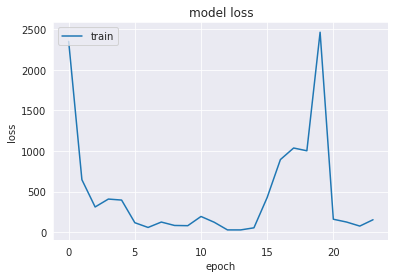

In [41]:
if not nas:
    history = history_list[-1]

    plt.plot(history['loss'])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/loss_' + path_identifier_interpretation_net_data + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')    


### Multi Epoch/Sampes Analysis

### Generate Comparison Plots

0.001

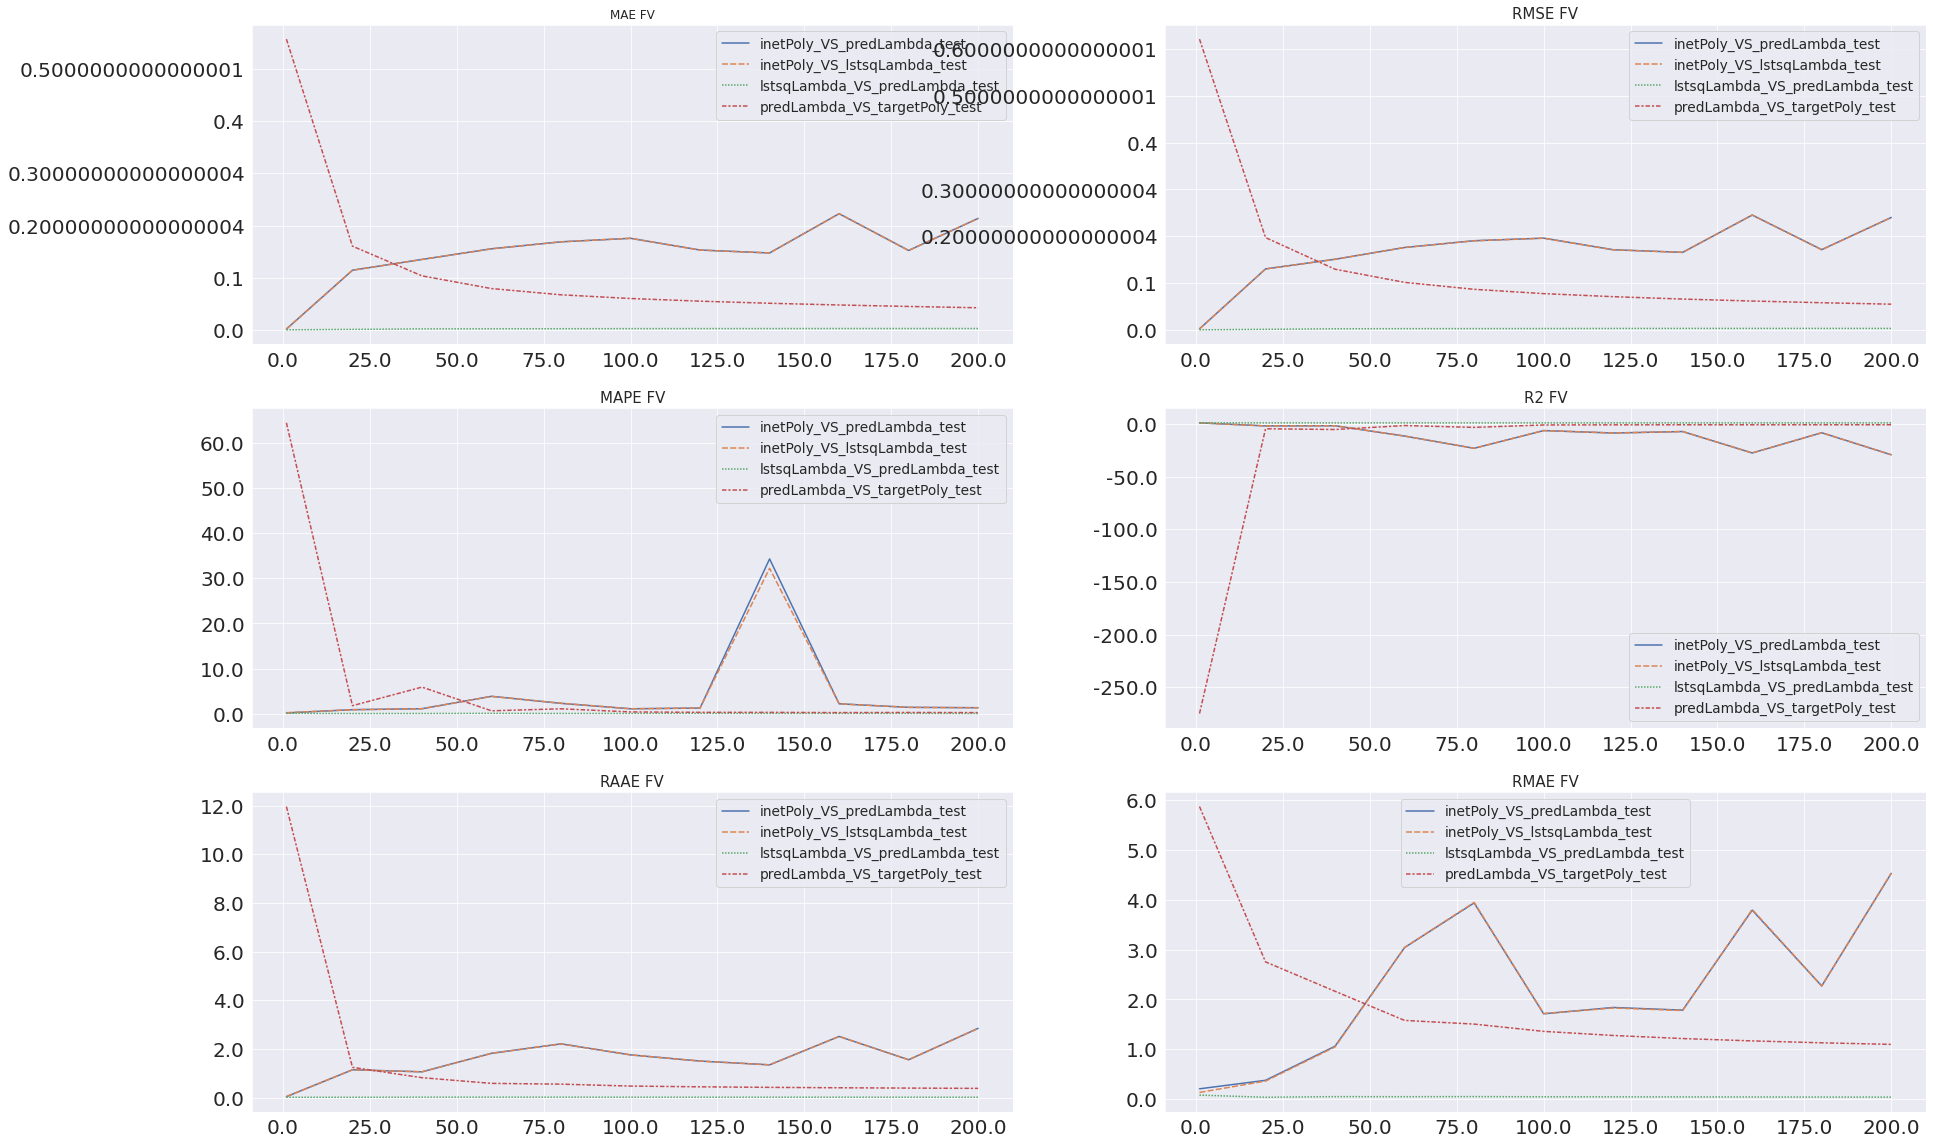

In [42]:
if len(scores_list) > 1:
    plot_metric_list = ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV']

    generate_inet_comparison_plot(scores_list, plot_metric_list)

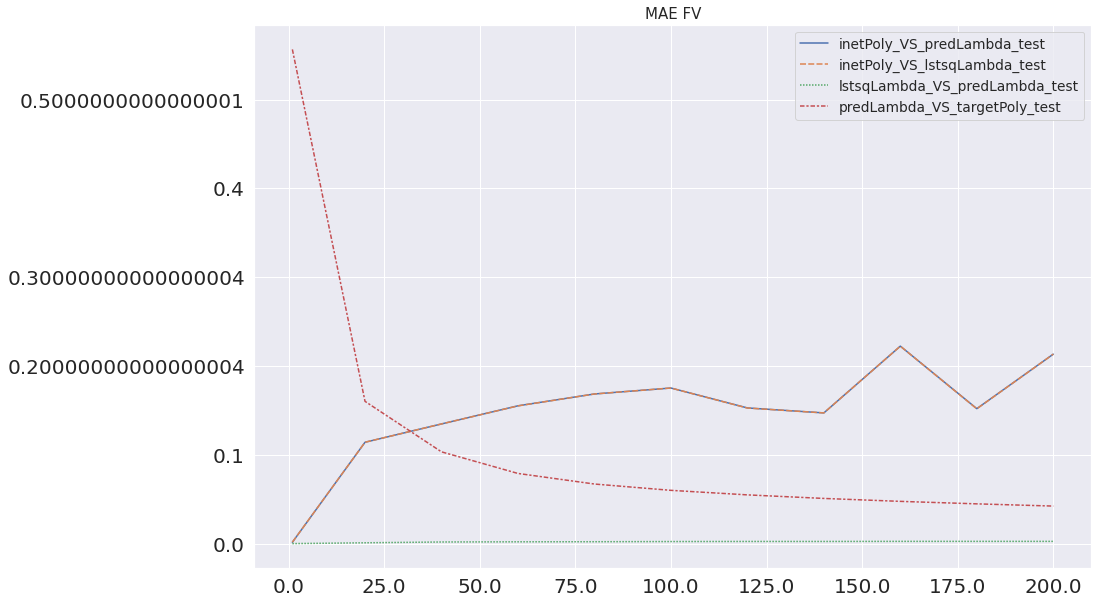

In [43]:
if len(scores_list) > 1:
    plot_metric_list = ['MAE FV']

    generate_inet_comparison_plot(scores_list, plot_metric_list)

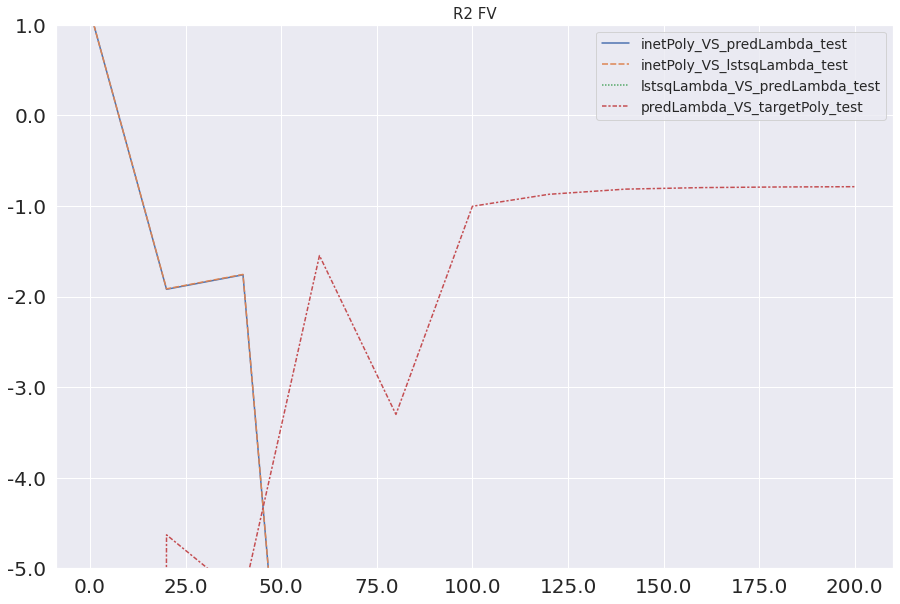

In [44]:
if len(scores_list) > 1:
    plot_metric_list = ['R2 FV']

    generate_inet_comparison_plot(scores_list, plot_metric_list, ylim=(-5, 1))

#### Generate and Analyze Predictions for Random Function

In [45]:
index = 43

polynomial_target = lambda_net_test_dataset.target_polynomial_list[index]
polynomial_lstsq_target = lambda_net_test_dataset.lstsq_target_polynomial_list[index]
polynomial_lstsq_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index]
polynomial_inet = inet_preds_test_list[-1][index]

print('Target Poly:')
print_polynomial_from_coefficients(polynomial_target)
print('LSTSQ Target Poly:')
print_polynomial_from_coefficients(polynomial_lstsq_target)
print('LSTSQ Lambda Poly:')
print_polynomial_from_coefficients(polynomial_lstsq_lambda)
print('I-Net Poly:')
print_polynomial_from_coefficients(polynomial_inet)


Target Poly:


<IPython.core.display.Math object>

LSTSQ Target Poly:


<IPython.core.display.Math object>

LSTSQ Lambda Poly:


<IPython.core.display.Math object>

I-Net Poly:


<IPython.core.display.Math object>

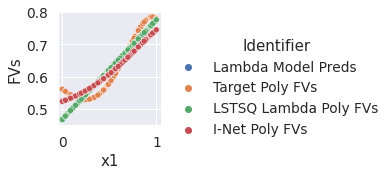

In [46]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      rand_index=index, 
                                                      plot_type=1)

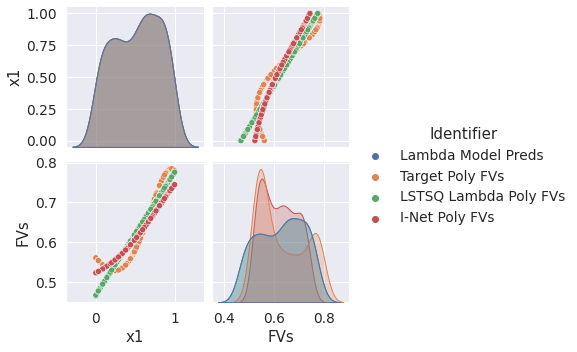

In [47]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      rand_index=index, 
                                                      plot_type=2)

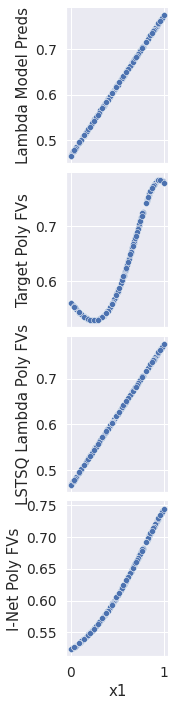

In [48]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      rand_index=index, 
                                                      plot_type=3)

# BENCHMARK (RANDOM GUESS) EVALUATION

In [49]:
list_of_random_polynomials = np.random.uniform(low=-10, high=10, size=(len(lambda_net_test_dataset_list[-1]), sparsity))

In [50]:
true_fv_test = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].test_data_list)
random_fv_test = parallel_fv_calculation_from_polynomial(list_of_random_polynomials, lambda_net_test_dataset_list[-1].test_data_list)

In [51]:
print('Random Guess Error Coefficients: ' + str(np.round(mean_absolute_error(lambda_net_test_dataset_list[-1].target_polynomial_list, list_of_random_polynomials), 4)))

Random Guess Error Coefficients: 5.0389


In [52]:
print('Random Guess Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, random_fv_test), 4)))

Random Guess Error FVs: 6.3924


# BENCHMARK (EDUCATED GUESS/MEAN PREDICTION) EVALUATION

In [53]:
true_fv_train = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].test_data_list)

mean_fv = np.mean(true_fv_train)
mean_fv_pred_test = [mean_fv for _ in range(true_fv_test.shape[0])]

In [54]:
print('Educated Guess/Mean Prediction Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, mean_fv_pred_test), 4)))

Educated Guess/Mean Prediction Error FVs: 0.6153


In [55]:
%%script false --no-raise-error

base_model = generate_base_model()
random_evaluation_dataset = np.random.uniform(low=x_min, high=x_max, size=(random_evaluation_dataset_size, n))
#random_evaluation_dataset = lambda_train_input_train_split[0]#lambda_train_input[0] #JUST [0] HERE BECAUSE EVALUATION ALWAYS ON THE SAME DATASET FOR ALL!!
list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)


loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

#X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))


seed_in_inet_training = False

loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))

seed_in_inet_training = True



In [56]:
if use_gpu:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()